In [1]:
import numpy as np
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from PIL import Image
from io import BytesIO
from trajectory_visualizer import TrajectoryVisualizer

In [2]:
with open("simulated_stroke_data/strokes.npy", "rb") as f:
    strokes = np.load(f)
with open("simulated_stroke_data/trajectories.npy", "rb") as f:
    trajectories = np.load(f)

strokes = torch.from_numpy(strokes).float()
trajectories = torch.from_numpy(trajectories).float()

In [3]:
tv = TrajectoryVisualizer(-1, 1, -1, 1, 0, 1)

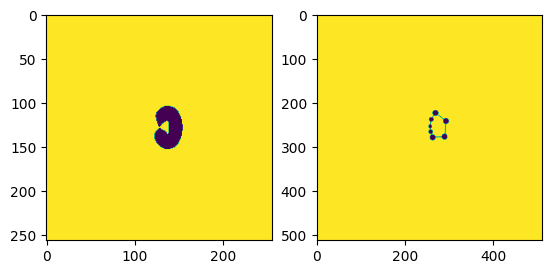

In [45]:
idx = 206
_, axs = plt.subplots(1,2)
axs[0].imshow(strokes[idx])
axs[1].imshow(tv.visualize_trajectory(trajectories[idx]))

In [21]:
from StrokeTrajDataset import StrokeTrajDataset
from SimBetaVAE import SimBetaVAE
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import wandb
from sklearn.manifold import TSNE
import plotly.express as px

wandb.init(project="diverse-strokes", mode="online")

max_capacity = 0
beta = 0.001
num_epochs = 1000
epochs_per_save = 50
schedule = "cyclical"
duration = 100

wandb.config = {
    "epochs": num_epochs,
    "beta": beta,
    "max_capacity": max_capacity,
    "schedule": schedule,
    "duration": duration
}

def get_beta(step):
    # if schedule="constant", always return beta
    # if schedule="monotonic", increase linearly to beta until duration, at which it stays constant
    # if schedule="cyclical", increase from 0 to beta over duration steps, stay constant for duration more steps, and repeat
    if schedule == "constant":
        return beta
    elif schedule == "monotonic":
        return min(beta * step/duration, beta)
    elif schedule == "cyclical":
        step = step % (2*duration)
        return min(beta * step/duration, beta)
    else:
        raise ValueError("invalid schedule")

resize64 = torchvision.transforms.Resize((64, 64), antialias=True)
resize512 = torchvision.transforms.Resize((512, 512), antialias=True)
resized_strokes = resize64(strokes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

model = SimBetaVAE()
model.to(device)
optimizer = optim.Adam(model.parameters())

train_test_split = int(0.8 * len(resized_strokes))
from sklearn.utils import shuffle
s, t = shuffle(resized_strokes, trajectories, random_state=0)
train = s[:train_test_split], t[:train_test_split]
test = s[train_test_split:], t[train_test_split:]

train_dataset = StrokeTrajDataset(*train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = StrokeTrajDataset(*test)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

def plot_embeddings(model, data):
    # data: [[class, strokes, trajectories], [class, strokes, trajectories], ...] where each subarray is a different class
    encodings = []
    classes = []
    for (c, strokes, trajectories) in data:
        dataset = StrokeTrajDataset(strokes, trajectories)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
        classes += [c for _ in range(len(dataset))]
        for (stroke, trajectory) in dataloader:
            stroke = stroke.to(device)
            trajectory = trajectory.to(device)
            mean, _ = model.encode(stroke, trajectory)
            encodings.append(mean)
    encodings = torch.concat(encodings, axis=0) # n x 5
    encodings = encodings.cpu().detach()
    reduced_encodings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(encodings)
    fig = px.scatter(x=reduced_encodings[:,0], y=reduced_encodings[:,1], color=classes)
    return fig

def validation(model, dataloader):
    model.eval()
    total_loss = 0
    originals = []
    decoder_outputs = []
    
    for (stroke,trajectory) in dataloader:
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        args = model(stroke, trajectory)
        loss = model.reconstruction_loss(args)
        total_loss += loss * batch_size
        
        for i in range(batch_size):
            stroke_dec = args[0][0][i].squeeze(0).cpu().detach()
            traj_dec = args[0][1][i].cpu().detach()
            decoder_outputs.append((stroke_dec, traj_dec))
            stroke = args[1][0][i].squeeze(0).cpu().detach()
            traj = args[1][1][i].cpu().detach()
            originals.append((stroke, traj))

    avg_loss = total_loss / len(dataloader.dataset)
    model.train()
    return avg_loss, decoder_outputs, originals

fig = plot_embeddings(
    model,
    [
        ["bezier", resized_strokes[:200], trajectories[:200]],
        ["circle", resized_strokes[200:], trajectories[200:]]
    ]
)
wandb.log({"embeddings": fig})

for epoch in range(num_epochs):
    cur_beta = get_beta(epoch)
    capacity = epoch / num_epochs * max_capacity
    total_loss = 0
    for (i, (stroke, trajectory)) in enumerate(train_dataloader):
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        args = model(stroke, trajectory)
        loss = model.loss(args, cur_beta, capacity)
        
        total_loss += loss * batch_size
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == 0 and epoch%epochs_per_save == epochs_per_save-1:
            output_dir = f"training_outputs/epoch{epoch}/train"
            os.makedirs(output_dir, exist_ok=True)
            for i in range(batch_size):
                stroke_dec = args[0][0][i].squeeze(0).cpu().detach()
                stroke_dec_img = resize512(stroke_dec.unsqueeze(0).unsqueeze(0))
                traj_dec = args[0][1][i].cpu().detach()
                traj_dec_img = tv.visualize_trajectory(traj_dec).float()
                stroke = args[1][0][i].squeeze(0).cpu().detach()
                stroke_img = resize512(stroke.unsqueeze(0).unsqueeze(0))
                traj = args[1][1][i].cpu().detach()
                traj_img =  tv.visualize_trajectory(traj).float()

                images = [
                    wandb.Image(stroke_dec_img, caption='decoded stroke intensities'),
                    wandb.Image(stroke_img, caption='original stroke intensities'),
                    wandb.Image(traj_dec_img, caption='decoded trajectory'),
                    wandb.Image(traj_img, caption='original trajectory')
                ]
                wandb.log({"training outputs": images})
                # plt.imsave(f"{output_dir}/{i}-decoded.png", stroke_dec)
                # plt.imsave(f"{output_dir}/{i}-original.png", stroke)
                # plt.imsave(f"{output_dir}/{i}-traj_decoded.png", tv.visualize_trajectory(traj_dec))
                # plt.imsave(f"{output_dir}/{i}-traj_original.png", tv.visualize_trajectory(traj))
    
    train_loss = total_loss / len(train_dataset)
    val_loss, decoded_list, original_list = validation(model, val_dataloader)
    wandb.log({
        'epoch': epoch,
        'capacity': capacity,
        'cur_beta': cur_beta,
        'train_loss': train_loss,
        'val_loss': val_loss
    })

    if epoch%epochs_per_save == epochs_per_save-1:
        output_dir = f"training_outputs/epoch{epoch}/val"
        os.makedirs(output_dir, exist_ok=True)
        for i in range(len(decoded_list)):
            stroke_dec, traj_dec = decoded_list[i][0], decoded_list[i][1]
            stroke, traj = original_list[i][0], original_list[i][1]
            stroke_dec_img = resize512(stroke_dec.unsqueeze(0).unsqueeze(0))
            traj_dec_img = tv.visualize_trajectory(traj_dec).float()
            stroke_img = resize512(stroke.unsqueeze(0).unsqueeze(0))
            traj_img =  tv.visualize_trajectory(traj).float()

            images = [
                wandb.Image(stroke_dec_img, caption='decoded stroke intensities'),
                wandb.Image(stroke_img, caption='original stroke intensities'),
                wandb.Image(traj_dec_img, caption='decoded trajectory'),
                wandb.Image(traj_img, caption='original trajectory')
            ]
            wandb.log({"validation outputs": images})
            # plt.imsave(f"{output_dir}/{i}-decoded.png", stroke_dec)
            # plt.imsave(f"{output_dir}/{i}-original.png", stroke)
            # plt.imsave(f"{output_dir}/{i}-traj_decoded.png", tv.visualize_trajectory(traj_dec))
            # plt.imsave(f"{output_dir}/{i}-traj_original.png", tv.visualize_trajectory(traj))
        fig = plot_embeddings(
            model,
            [
                ["bezier", resized_strokes[:200], trajectories[:200]],
                ["circle", resized_strokes[200:], trajectories[200:]]
            ]
        )
        wandb.log({"embeddings": fig})
    
    print(f"Epoch {epoch}: Train loss={train_loss}, Validation loss={val_loss}")

capacity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cur_beta,▁▂▃▅▆██████▁▃▄▆▇██████▂▃▅▆██████▁▂▄▅▆███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▇▇▇▇███████▁▃▅▆▇▇▇▇▇▇▇▂▄▅▆▇▇▇▇▇▇▁▂▄▅▆▇▇▇
val_loss,▆▅▆▆█▇▇█▇▇▇▂▃▅▅▅▇▅▆▅▇▆▂▃▄▅▅▄▆▆▆▅▁▂▃▃▅▆▅▇
capacity,0.0
cur_beta,0.01
epoch,749
train_loss,0.0289
val_loss,0.0143


Epoch 0: Train loss=0.7059871554374695, Validation loss=0.6253353357315063
Epoch 1: Train loss=0.13228750228881836, Validation loss=0.10762816667556763
Epoch 2: Train loss=0.061828505247831345, Validation loss=0.04268481209874153
Epoch 3: Train loss=0.035629138350486755, Validation loss=0.027012694627046585
Epoch 4: Train loss=0.025594282895326614, Validation loss=0.020961908623576164
Epoch 5: Train loss=0.021408259868621826, Validation loss=0.017230382189154625
Epoch 6: Train loss=0.018672270700335503, Validation loss=0.0166988093405962
Epoch 7: Train loss=0.01618431881070137, Validation loss=0.013045514933764935
Epoch 8: Train loss=0.01487664133310318, Validation loss=0.01104286964982748
Epoch 9: Train loss=0.013312838971614838, Validation loss=0.00889243558049202
Epoch 10: Train loss=0.012268044985830784, Validation loss=0.00891271885484457
Epoch 11: Train loss=0.01164785772562027, Validation loss=0.009933216497302055
Epoch 12: Train loss=0.011522782035171986, Validation loss=0.0069

wandb: Network error resolved after 0:00:03.426624, resuming normal operation.


Epoch 599: Train loss=0.007295769639313221, Validation loss=0.0037572875153273344
Epoch 600: Train loss=0.0017525965813547373, Validation loss=0.002263376023620367
Epoch 601: Train loss=0.0009202102082781494, Validation loss=0.0007713104132562876
Epoch 602: Train loss=0.0006955501739867032, Validation loss=0.0006415094248950481
Epoch 603: Train loss=0.000741196854505688, Validation loss=0.0005683467024937272
Epoch 604: Train loss=0.0008019583183340728, Validation loss=0.0004930315189994872
Epoch 605: Train loss=0.000850358628667891, Validation loss=0.00045683979988098145
Epoch 606: Train loss=0.0009243136155419052, Validation loss=0.0004935441538691521
Epoch 607: Train loss=0.001025406294502318, Validation loss=0.0004956551711075008
Epoch 608: Train loss=0.0011168806813657284, Validation loss=0.0004456607566680759
Epoch 609: Train loss=0.001197192701511085, Validation loss=0.0004514223837759346
Epoch 610: Train loss=0.0012846881290897727, Validation loss=0.0005289022228680551
Epoch 611

wandb: Network error resolved after 0:00:03.269858, resuming normal operation.


Epoch 749: Train loss=0.007060871925204992, Validation loss=0.002337665995582938
Epoch 750: Train loss=0.0069542150013148785, Validation loss=0.0020134735386818647
Epoch 751: Train loss=0.007039956282824278, Validation loss=0.0022349797654896975
Epoch 752: Train loss=0.006932047661393881, Validation loss=0.002559962449595332
Epoch 753: Train loss=0.007028918247669935, Validation loss=0.0027767433784902096
Epoch 754: Train loss=0.006879365537315607, Validation loss=0.0030277674086391926
Epoch 755: Train loss=0.007107854820787907, Validation loss=0.002773160580545664
Epoch 756: Train loss=0.006849038880318403, Validation loss=0.003354141488671303
Epoch 757: Train loss=0.007132214959710836, Validation loss=0.0023844572715461254
Epoch 758: Train loss=0.007238020654767752, Validation loss=0.002549530239775777
Epoch 759: Train loss=0.007249172776937485, Validation loss=0.0026244951877743006
Epoch 760: Train loss=0.007149329874664545, Validation loss=0.0021267819683998823
Epoch 761: Train los

wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: 429 encountered ({

Epoch 799: Train loss=0.0071329050697386265, Validation loss=0.002692794194445014
Epoch 800: Train loss=0.0017521802801638842, Validation loss=0.001660298788920045
Epoch 801: Train loss=0.0008545498712919652, Validation loss=0.0009109596139751375
Epoch 802: Train loss=0.0007193146157078445, Validation loss=0.0007097762427292764
Epoch 803: Train loss=0.0006876109400764108, Validation loss=0.0005672244005836546
Epoch 804: Train loss=0.0007328986539505422, Validation loss=0.0004841435293201357
Epoch 805: Train loss=0.0008020263048820198, Validation loss=0.0005263251368887722
Epoch 806: Train loss=0.0009100076858885586, Validation loss=0.0005944689619354904
Epoch 807: Train loss=0.0010015758452937007, Validation loss=0.0005269391695037484
Epoch 808: Train loss=0.0010552018648013473, Validation loss=0.0006101305480115116
Epoch 809: Train loss=0.0011257623555138707, Validation loss=0.0004736317787319422
Epoch 810: Train loss=0.001198627520352602, Validation loss=0.0005476076621562243
Epoch 8

wandb: 429 encountered ({"error":"rate limit exceeded"}), retrying request
wandb: Network error resolved after 0:00:03.507819, resuming normal operation.


Epoch 899: Train loss=0.0066795386373996735, Validation loss=0.0033391546458005905
Epoch 900: Train loss=0.006883692927658558, Validation loss=0.002481624484062195
Epoch 901: Train loss=0.007070228457450867, Validation loss=0.0025090931449085474
Epoch 902: Train loss=0.006905237678438425, Validation loss=0.0027436777018010616
Epoch 903: Train loss=0.0069742584601044655, Validation loss=0.005299869924783707
Epoch 904: Train loss=0.007061412092298269, Validation loss=0.0025243174750357866
Epoch 905: Train loss=0.007080925162881613, Validation loss=0.002056783763691783
Epoch 906: Train loss=0.006939515005797148, Validation loss=0.0032408114057034254
Epoch 907: Train loss=0.0068728565238416195, Validation loss=0.0026344095822423697
Epoch 908: Train loss=0.007155997212976217, Validation loss=0.0027043845038861036
Epoch 909: Train loss=0.007177192717790604, Validation loss=0.0021495947148650885
Epoch 910: Train loss=0.006862327456474304, Validation loss=0.003192577976733446
Epoch 911: Train 

wandb: Network error resolved after 0:00:00.088516, resuming normal operation.


Epoch 999: Train loss=0.006809433456510305, Validation loss=0.002138109179213643


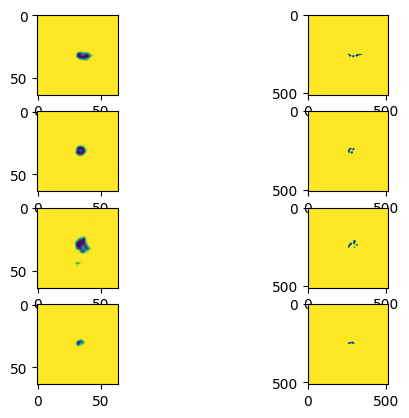

In [32]:
s, t = model.sample_latent(4)
_, axs = plt.subplots(4, 2)
for i in range(4):
    axs[i][0].imshow(s[i].squeeze(0).cpu().detach())
    axs[i][1].imshow(tv.visualize_trajectory(t[i].cpu().detach()))

In [24]:
def no_gap_plot(data): # https://stackoverflow.com/questions/42675864/how-to-remove-gaps-between-image-subplots
    # data: N x M x individual image
    N = len(data)
    M = len(data[0])
    heights = [50 for a in data]
    widths = [50 for a in data[0]]
    
    fig_width = 8.  # inches
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axarr = plt.subplots(N,M, figsize=(fig_width, fig_height), gridspec_kw={'height_ratios':heights})

    for i in range(N):
        for j in range(M):
            axarr[i, j].imshow(data[i][j])
            axarr[i, j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

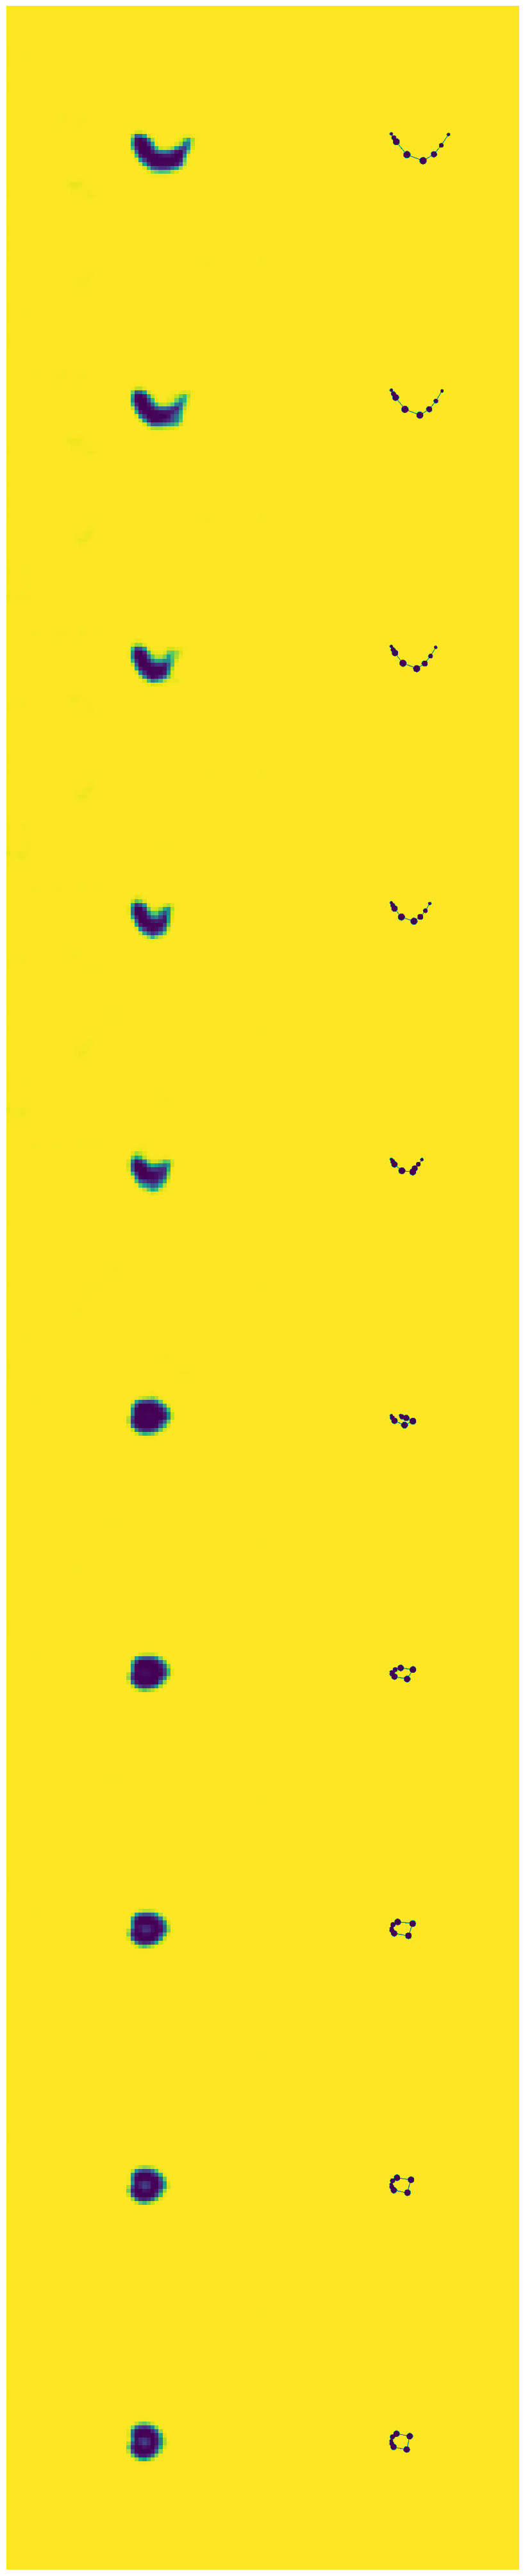

In [25]:
# Interpolating between strokes
def interpolate(idx0, idx1):
    s = resize64(strokes)
    t = trajectories
    s0 = s[idx0].unsqueeze(0).unsqueeze(0).to(device)
    t0 = t[idx0].unsqueeze(0).to(device)
    s1 = s[idx1].unsqueeze(0).unsqueeze(0).to(device)
    t1 = t[idx1].unsqueeze(0).to(device)
    enc0, _ = model.encode(s0, t0)
    enc1, _ = model.encode(s1, t1)
    
    num_images = 10
    data = []
    for i in range(num_images):
        t = i / (num_images - 1)
        enc = enc0*(1-t) + enc1*t
        stroke, trajectory = model.decode(enc)
        stroke = stroke.cpu().detach().reshape((64, 64))
        trajectory = tv.visualize_trajectory(trajectory.cpu().detach().squeeze(0))
        data.append([stroke, trajectory])
    no_gap_plot(data)

interpolate(11, 202)

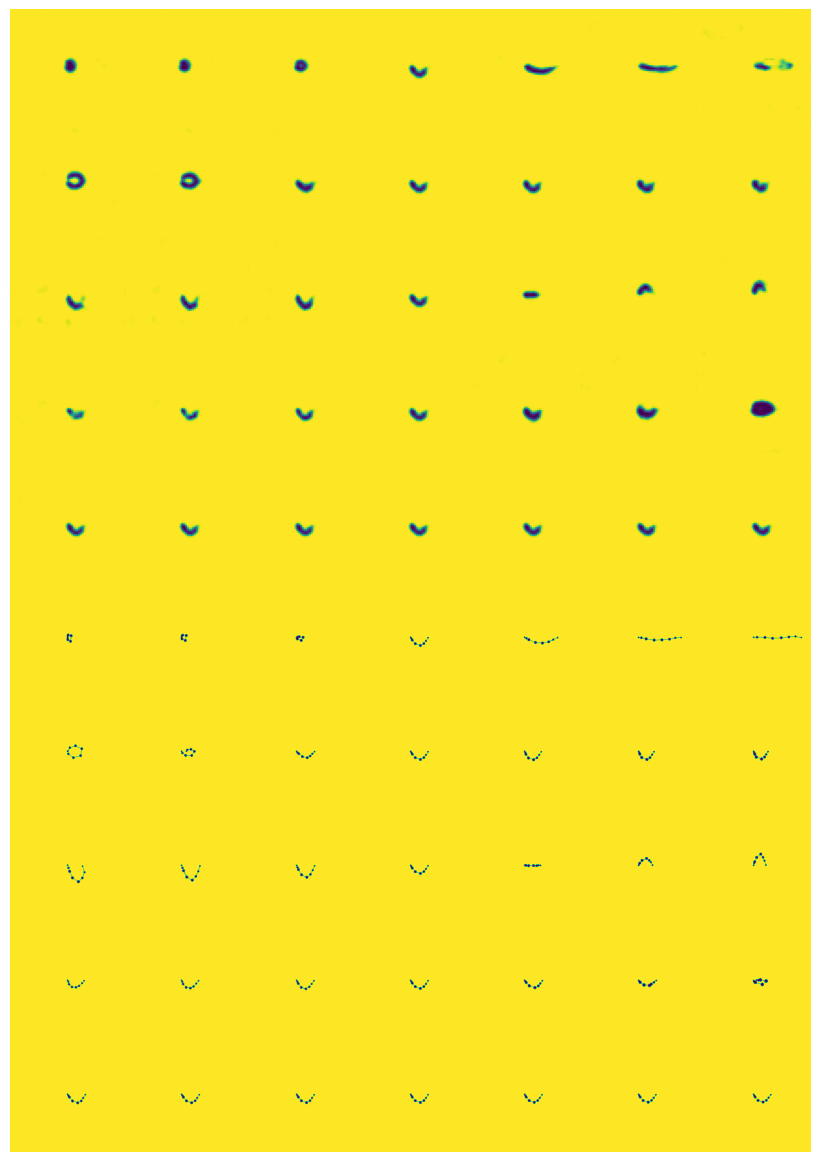

In [26]:
# Varying different latent variables at a time
def vary_one_at_a_time(idx):
    rs = resize64(strokes)
    s = rs[idx].unsqueeze(0).unsqueeze(0).to(device)
    t = trajectories[idx].unsqueeze(0).to(device)
    enc, _ = model.encode(s, t)
    s_data = []
    t_data = []
    for i in range(5):
        s_data_row = []
        t_data_row = []
        for j in range(-3, 4):
            shift = torch.zeros(5)
            shift[i] += j
            shift = shift.to(device)
            shifted = enc + shift
            stroke, trajectory = model.decode(shifted)
            stroke = stroke.cpu().detach().reshape((64, 64))
            trajectory = tv.visualize_trajectory(trajectory.cpu().detach().squeeze(0))
            s_data_row.append(stroke)
            t_data_row.append(trajectory)
        s_data.append(s_data_row)
        t_data.append(t_data_row)
    data = s_data + t_data
    no_gap_plot(data)
vary_one_at_a_time(0)